In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

c:\Users\Penguin\anaconda3\envs\evasion\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### DeepFool

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mo>&#x2206;</mo>
  <mo stretchy="false">(</mo>
  <mi>x</mi>
  <mo>;</mo>
  <mover>
    <mi>k</mi>
    <mo>&#x005E;</mo>
  </mover>
  <mo stretchy="false">)</mo>
  <mo>&#x2254;</mo>
  <munder>
    <mo>min</mo>
    <mrow>
      <mo>&#x23A3;</mo>
      <mi>r</mi>
      <mo>&#x23A6;</mo>
    </mrow>
  </munder>
  <mo>&#x2225;</mo>
  <mi>r</mi>
  <mo>&#x2225;</mo>
  <msub>
    <mn>_2</mn>
  </msub>
  <mtext> subject to </mtext>
  <mover>
    <mi>k</mi>
    <mo>&#x005E;</mo>
  </mover>
  <mo stretchy="false">(</mo>
  <mi>x</mi>
  <mo>+</mo>
  <mi>r</mi>
  <mo stretchy="false">)</mo>
  <mo>&#x2260;</mo>
  <mover>
    <mi>k</mi>
    <mo>&#x005E;</mo>
  </mover>
  <mo stretchy="false">(</mo>
  <mi>x</mi>
  <mo stretchy="false">)</mo>
</math>


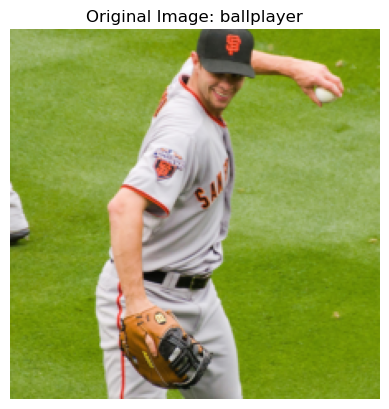

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
model.eval()

class_idx = json.load(open("../data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

input_image = "../data/person.jpg"

image = Image.open(input_image).convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

image_tensor = preprocess(image).unsqueeze(0).to(device)
output = model(image_tensor)
_, predict = torch.max(output, 1)

labels = idx2label[predict.item()]

original_image = image_tensor.squeeze(0).permute(1,2,0).detach().cpu().numpy()
original_image = np.clip(original_image, 0, 1)

plt.imshow(original_image)
plt.axis("off")
plt.title(f"Original Image: {labels}")
plt.show()

In [6]:
def deepfool(image, model, num_classes=10, overshoot=0.02, max_iter=50):
    image = image.clone().detach().requires_grad_(True)
    output = model(image)
    _, pred = torch.max(output.data, 1)

    input_shape = image.shape
    perturbation = torch.zeros(input_shape).to(device)
    w = torch.zeros(input_shape).to(device)
    r_tot = torch.zeros(input_shape).to(device)

    loop_i = 0

    x = image.clone().detach().requires_grad_(True)
    fs = model(x)
    k_i = pred

    while k_i.item() == pred.item() and loop_i < max_iter:
        pert = np.inf
        fs[0, k_i].backward(retain_graph=True)
        grad_orig = x.grad.data.clone()

        for k in range(num_classes):
            if k == k_i:
                continue
            x.grad.zero_()
            fs[0, k].backward(retain_graph=True)
            cur_grad = x.grad.data.clone()

            w_k = cur_grad - grad_orig
            f_k = (fs[0, k] - fs[0, k_i]).data

            pert_k = torch.abs(f_k) / torch.norm(w_k.flatten())

            if pert_k < pert:
                pert = pert_k
                w = w_k

        r_i = (pert + 1e-4) * w / torch.norm(w)
        r_tot = r_tot + r_i

        x = image + (1 + overshoot) * r_tot
        x = torch.clamp(x, 0, 1).detach().requires_grad_(True)
        fs = model(x)
        k_i = torch.argmax(fs.data, 1)

        loop_i += 1

    r_tot = (1 + overshoot) * r_tot
    return r_tot, loop_i, k_i

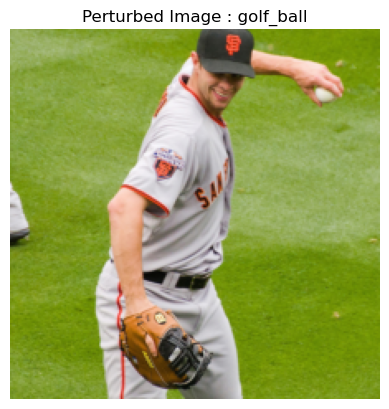

In [7]:
perturbation, loop_i, k_i = deepfool(image_tensor, model)
adversarial_image = image_tensor + perturbation
adversarial_image = torch.clamp(adversarial_image, 0, 1)

adversarial_output = model(adversarial_image)
_, adversarial_predict = torch.max(adversarial_output, 1)
adversarial_labels = idx2label[adversarial_predict.item()]

# print(adversarial_labels)

# adversarial
perturbed_image = adversarial_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
perturbed_image = np.clip(perturbed_image, 0, 1)

plt.imshow(perturbed_image)
plt.title(f'Perturbed Image : {adversarial_labels}')
plt.axis('off')
plt.show()